# System identification revisited

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
pd.set_option('max_colwidth', -1)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, track_plots, plot
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
from vessel_manoeuvring_models.models.vmm_martin_simple import martins_simple_model as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [3]:
import anyconfig
globals_path = "../conf/base/globals.yml"
global_variables = anyconfig.load(globals_path)
ships = global_variables["ships"]

In [4]:
ships

['M5064-02-A', 'wPCC']

In [5]:
%reload_kedro
ship='wPCC'
time_series = catalog.load(f"{ship}.time_series")
ship_data = catalog.load(f"{ship}.ship_data")
thrust_keys = catalog.load(f"params:{ship}.thrust_keys")
exclude_parameters = catalog.load(f"params:{ship}.exclude_parameters")
time_series_meta_data = catalog.load(f"{ship}.time_series_meta_data")
time_series_meta_data.index = time_series_meta_data.index.astype(str)
time_series_meta_data.rename(columns={'test_type':'test type'}, inplace=True)

[04/25/23 17:58:58] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=248842;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=935809;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[04/25/23 17:59:00] INFO     Kedro project phd                                                      ]8;id=567964;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=540236;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=260147;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=37586;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Loading data from 'wPCC.time_series' (PartitionedDataSet)...       ]8;id=632918;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=292065;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=304148;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=539156;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:wPCC.thrust_keys' (MemoryDataSet)...     ]8;id=808224;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=568134;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:wPCC.exclude_parameters'                 ]8;id=891487;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=230937;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from 'wPCC.time_series_meta_data' (CSVDataSet)...     ]8;id=491413;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=526842;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [6]:
ship_data

{'T': 0.2063106796116504,
 'L': 5.014563106796117,
 'CB': 0.45034232324249973,
 'B': 0.9466019417475728,
 'rho': 1000,
 'x_G': 0,
 'm': 441.0267843660858,
 'I_z': 693.124396594905,
 'volume': 0.4410267843660858,
 'scale_factor': 41.2,
 'x_r': -2.42219908951329,
 'TWIN': 1,
 'x_p': -2.42219908951329,
 'D': 0.12135922330097086,
 'w_p0': 0.151}

In [7]:
time_series_meta_data.head()

,project_number,series_number,run_number,test_number,model_number,ship_name,loading_condition_id,ascii_name,ship_speed,comment,file_path_ascii,file_path_ascii_temp,file_path_log,file_path_hdf5,date,test type,facility,angle1,angle2,scale_factor,name,lcg,kg,gm,CW,TF,TA,BWL,KXX,KZZ,BTT1,CP,Volume,A0,RH,lpp,beam,ABULB,BKX,TWIN,DCLR,VDES,RHBL,ASKEG,PD,ARH,CFP,AIX,PDTDES,RTYPE,SFP,BKL,BKB,PROT,D,LSKEG,RR,XSKEG,NDES,AR,BR,BRA,IRUD,PTYPE,XRUD,AI,HSKEG,RSKEG,LOA,ship_type_id,xm,ym,zm,description
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
22639,40199079,1,4,12,M5139-02-A,M5139-02-A,167,NaN,0.641180,8.0 kn,NaN,NaN,NaN,\\sspa.local\lab\MeasuredataMDL\40199079\001\012\MDL-Proj40199079-Ser001-Test012-Run004.hdf5,2020-10-02,reference speed,MDL,NaN,NaN,41.2,Design,-0.24432,0.438908,0.136092,NaN,0.206311,0.206311,NaN,0.331311,1.253641,NaN,NaN,0.441027,0.722775,NaN,5.014563,0.946602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-0.214,Reference speed 0.6 m/s
22638,40199079,1,3,12,M5139-02-A,M5139-02-A,167,NaN,0.641180,8.0 kn,NaN,NaN,NaN,\\sspa.local\lab\MeasuredataMDL\40199079\001\012\MDL-Proj40199079-Ser001-Test012-Run003.hdf5,2020-10-02,reference speed,MDL,NaN,NaN,41.2,Design,-0.24432,0.438908,0.136092,NaN,0.206311,0.206311,NaN,0.331311,1.253641,NaN,NaN,0.441027,0.722775,NaN,5.014563,0.946602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-0.214,Reference speed 0.6 m/s
22637,40199079,1,2,12,M5139-02-A,M5139-02-A,167,NaN,0.641180,8.0 kn,NaN,NaN,NaN,\\sspa.local\lab\MeasuredataMDL\40199079\001\012\MDL-Proj40199079-Ser001-Test012-Run002.hdf5,2020-10-02,reference speed,MDL,NaN,NaN,41.2,Design,-0.24432,0.438908,0.136092,NaN,0.206311,0.206311,NaN,0.331311,1.253641,NaN,NaN,0.441027,0.722775,NaN,5.014563,0.946602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-0.214,Reference speed 0.6 m/s
22636,40199079,1,1,12,M5139-02-A,M5139-02-A,167,NaN,0.641180,8.0 kn,NaN,NaN,NaN,\\sspa.local\lab\MeasuredataMDL\40199079\001\012\MDL-Proj40199079-Ser001-Test012-Run001.hdf5,2020-10-02,reference speed,MDL,NaN,NaN,41.2,Design,-0.24432,0.438908,0.136092,NaN,0.206311,0.206311,NaN,0.331311,1.253641,NaN,NaN,0.441027,0.722775,NaN,5.014563,0.946602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-0.214,Reference speed 0.6 m/s
22634,40199079,1,4,10,M5139-02-A,M5139-02-A,167,NaN,0.801475,10.0 kn,NaN,NaN,NaN,\\sspa.local\lab\MeasuredataMDL\40199079\001\010\MDL-Proj40199079-Ser001-Test010-Run004.hdf5,2020-10-06,reference speed,MDL,NaN,NaN,41.2,Design,-0.24432,0.438908,0.136092,NaN,0.206311,0.206311,NaN,0.331311,1.253641,NaN,NaN,0.441027,0.722775,NaN,5.014563,0.946602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-0.214,Reference speed 0.8 m/s


In [8]:
time_series_meta_data['test type'].unique()

array(['reference speed', 'sailing', 'turning circle', 'rodergrundvinkel',
       'zigzag'], dtype=object)

In [9]:
time_series_meta_data.groupby(by='test type').get_group('zigzag').head()

,project_number,series_number,run_number,test_number,model_number,ship_name,loading_condition_id,ascii_name,ship_speed,comment,file_path_ascii,file_path_ascii_temp,file_path_log,file_path_hdf5,date,test type,facility,angle1,angle2,scale_factor,name,lcg,kg,gm,CW,TF,TA,BWL,KXX,KZZ,BTT1,CP,Volume,A0,RH,lpp,beam,ABULB,BKX,TWIN,DCLR,VDES,RHBL,ASKEG,PD,ARH,CFP,AIX,PDTDES,RTYPE,SFP,BKL,BKB,PROT,D,LSKEG,RR,XSKEG,NDES,AR,BR,BRA,IRUD,PTYPE,XRUD,AI,HSKEG,RSKEG,LOA,ship_type_id,xm,ym,zm,description
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
22775,40199079,5,2,5,M5139-02-A,M5139-02-A,167,NaN,0.96177,ZZ 10/10PS,NaN,NaN,NaN,\\sspa.local\lab\MeasuredataMDL\40199079\005\005\MDL-Proj40199079-Ser005-Test005-Run002.hdf5,2020-10-09,zigzag,MDL,NaN,NaN,41.2,Design,-0.24432,0.438908,0.136092,NaN,0.206311,0.206311,NaN,0.331311,1.253641,NaN,NaN,0.441027,0.722775,NaN,5.014563,0.946602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-0.214,ZigZag
22762,40199079,5,1,1,M5139-02-A,M5139-02-A,167,NaN,0.96177,ZZ 10/10SB,NaN,NaN,NaN,\\sspa.local\lab\MeasuredataMDL\40199079\005\001\MDL-Proj40199079-Ser005-Test001-Run001.hdf5,2020-09-23,zigzag,MDL,10.0,10.0,41.2,Design,-0.24432,0.438908,0.136092,NaN,0.206311,0.206311,NaN,0.331311,1.253641,NaN,NaN,0.441027,0.722775,NaN,5.014563,0.946602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-0.214,ZigZag10/10
22765,40199079,5,1,2,M5139-02-A,M5139-02-A,167,NaN,0.96177,ZZ 10/10PS,NaN,NaN,NaN,\\sspa.local\lab\MeasuredataMDL\40199079\005\002\MDL-Proj40199079-Ser005-Test002-Run001.hdf5,2020-09-23,zigzag,MDL,10.0,10.0,41.2,Design,-0.24432,0.438908,0.136092,NaN,0.206311,0.206311,NaN,0.331311,1.253641,NaN,NaN,0.441027,0.722775,NaN,5.014563,0.946602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-0.214,ZigZag10/10
22763,40199079,5,2,1,M5139-02-A,M5139-02-A,167,NaN,0.96177,ZZ 10/10SB,NaN,NaN,NaN,\\sspa.local\lab\MeasuredataMDL\40199079\005\001\MDL-Proj40199079-Ser005-Test001-Run002.hdf5,2020-09-24,zigzag,MDL,10.0,10.0,41.2,Design,-0.24432,0.438908,0.136092,NaN,0.206311,0.206311,NaN,0.331311,1.253641,NaN,NaN,0.441027,0.722775,NaN,5.014563,0.946602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-0.214,ZigZag10/10
22764,40199079,5,3,1,M5139-02-A,M5139-02-A,167,NaN,0.96177,ZZ 10/10SB,NaN,NaN,NaN,\\sspa.local\lab\MeasuredataMDL\40199079\005\001\MDL-Proj40199079-Ser005-Test001-Run003.hdf5,2020-09-24,zigzag,MDL,10.0,10.0,41.2,Design,-0.24432,0.438908,0.136092,NaN,0.206311,0.206311,NaN,0.331311,1.253641,NaN,NaN,0.441027,0.722775,NaN,5.014563,0.946602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-0.214,ZigZag10/10


In [10]:
id = 22772
data_raw = time_series[str(id)]()

In [11]:
data_raw.head()

,Arr/Ind/Arr,Arr/Ind/Fri,Fan/Aft/Angle,Fan/Aft/AngleOrder,Fan/Aft/Fx,Fan/Aft/FxOrder,Fan/Aft/Rpm,Fan/Aft/RpmOrder,Fan/ForceFactor,Fan/Fore/Angle,Fan/Fore/AngleOrder,Fan/Fore/Fx,Fan/Fore/FxOrder,Fan/Fore/Rpm,Fan/Fore/RpmOrder,Hull/Acc/X1,Hull/Acc/Y1,Hull/Acc/Y2,Hull/Acc/Z1,Hull/Acc/Z2,Hull/Acc/Z3,Prop/PS/Rpm,Prop/PS/Thrust,Prop/PS/Torque,Prop/SB/Rpm,Prop/SB/Thrust,Prop/SB/Torque,delta,Rudder/MaxAngle,Rudder/Rate,Wind/Course,Wind/CourseTreshold,Wind/GWA,lab/WaveHeight,roll,pitch,psi,x0,y0,z0
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
16.520018,0.0,1.0,2.146755,0.000027,0.187446,0.0,-0.520477,10.131507,1.0,2.146755,-0.000706,0.231210,0.0,-8.160022,11.329219,0.021273,-0.030895,0.007658,0.015050,-0.007220,0.012022,9.558658,5.450189,-0.108403,9.564930,5.347577,0.100852,0.000014,0.645772,14.89,-0.000144,0.1,0.0,0.000125,0.000890,-0.000171,-0.000611,7.327821,-0.000179,0.002440
16.529999,0.0,1.0,2.146755,0.000035,0.037287,0.0,0.212813,10.131507,1.0,2.146755,-0.000929,0.206990,0.0,-6.481174,11.329219,-0.010323,0.089009,0.017337,0.033088,0.010187,0.044245,9.574600,5.416779,-0.111748,9.556027,5.263566,0.099891,0.000014,0.645772,14.89,-0.000190,0.1,0.0,0.000125,0.000850,0.000083,-0.000524,7.338353,-0.000209,0.002590
16.540001,0.0,1.0,2.146755,0.000044,-0.170115,0.0,-0.366100,10.131507,1.0,2.146755,-0.001154,0.015996,0.0,-5.689993,11.329219,-0.014837,0.063223,0.017983,0.046616,0.009542,0.031356,9.653423,5.444381,-0.114711,9.565278,5.233857,0.100988,0.000020,0.645772,14.89,-0.000236,0.1,0.0,0.000125,0.000868,-0.000135,-0.000698,7.357075,-0.000161,0.002538
16.550019,0.0,1.0,2.146755,0.000052,-0.285948,0.0,-0.173129,10.131507,1.0,2.146755,-0.001382,-0.180430,0.0,0.157031,11.329219,0.005152,0.072248,0.005076,0.054991,0.022437,0.019756,9.623491,5.517160,-0.116242,9.534870,5.259566,0.103520,0.000014,0.645772,14.89,-0.000283,0.1,0.0,0.000125,0.000850,0.000102,-0.000611,7.357285,-0.000186,0.002512
16.560001,0.0,1.0,2.146755,0.000061,-0.218993,0.0,0.367190,10.131507,1.0,2.146755,-0.001606,-0.232356,0.0,-1.830571,11.329219,-0.010968,0.065157,0.014756,0.029223,0.016634,0.015245,9.603952,5.616301,-0.115943,9.572603,5.323262,0.106590,0.000014,0.645772,14.89,-0.000329,0.1,0.0,0.000125,0.000831,-0.000185,-0.000611,7.365260,-0.000190,0.002615


In [12]:
data = load(raw_data=data_raw)
data = add_thrust(data, thrust_channels=thrust_keys)

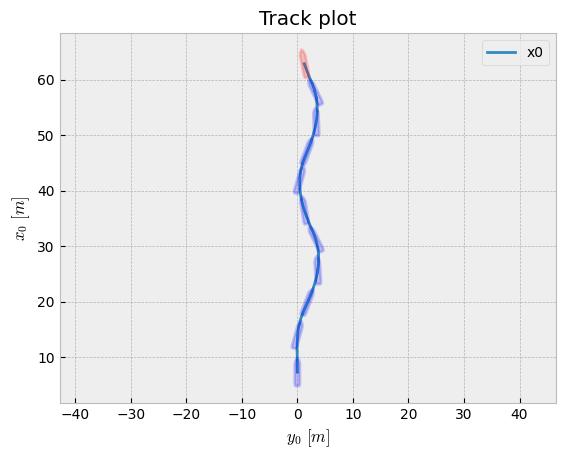

In [13]:
track_plot(df=data_raw, lpp=ship_data['L'], beam=ship_data['B']);

In [14]:
model_VCT = Simulator.load("model_VCT.pkl")

## Kalman filter system matrixes (-> f(...) and jacobi matrix)

In [34]:
vmm = VMM(X_eq=model_VCT.X_eq, Y_eq = model_VCT.Y_eq, N_eq = model_VCT.N_eq)

In [35]:
system_matrixes = SystemMatrixes(vmm=vmm)

In [36]:
system_matrixes._lambda_f

<function _lambdifygenerated(r, delta, thrust, m, Xthrust, v, Nrdot, Ydelta, Nr, Yrdot, u, Xu, I_z, x_G, Yvvv, Yr, Xdeltadelta, Nur, Ythrustdelta, Yv, Ndelta, L, psi, Yvdot, Nvdot, Nrrr, Nv, Nthrustdelta, Xvr, Xudot, rho, Yvr)>

In [37]:
system_matrixes._lambda_jacobian

<function _lambdifygenerated(r, delta, h, thrust, m, Xthrust, v, Nrdot, Nr, Ydelta, Yrdot, u, Xu, I_z, x_G, Yvvv, Yr, Xdeltadelta, Nur, Ythrustdelta, Yv, Ndelta, L, psi, Yvdot, Nvdot, Nrrr, Nv, Nthrustdelta, Xvr, Xudot, rho, Yvr)>

In [38]:
model_VCT.parameters

Xudot           0.000179
Xdeltadelta    -0.002388
Xthrust         0.883000
Xu             -0.000858
Xvr            -0.002060
Yrdot          -0.000303
Yvdot          -0.006109
Ydelta          0.005071
Yr              0.002749
Yvvv           -0.136030
Yv             -0.009478
Ythrustdelta    0.800000
Yvr             0.011530
Nrdot          -0.000299
Nvdot          -0.000128
Ndelta         -0.002463
Nrrr           -0.002874
Nr             -0.148474
Nv             -0.001440
Nthrustdelta   -0.386426
Nur             0.146496
dtype: float64

## model VCT initial guessed parameters

In [39]:
#parameters = {key:value for key,value in model_VCT.parameters.items() if not 'dot' in key}
parameters = model_VCT.parameters.to_dict()

In [40]:
parameters

{'Xudot': 0.00017880704448812042,
 'Xdeltadelta': -0.0023882950797979793,
 'Xthrust': 0.883,
 'Xu': -0.0008578977393015612,
 'Xvr': -0.0020600348550005856,
 'Yrdot': -0.00030313777458141895,
 'Yvdot': -0.006109387408263365,
 'Ydelta': 0.005070904026172081,
 'Yr': 0.00274908626901834,
 'Yvvv': -0.13603015841821203,
 'Yv': -0.009478116807560612,
 'Ythrustdelta': 0.8,
 'Yvr': 0.011529803823462739,
 'Nrdot': -0.00029867482773178765,
 'Nvdot': -0.00012825440172375716,
 'Ndelta': -0.0024626510333688027,
 'Nrrr': -0.002873622497682078,
 'Nr': -0.1484739657055087,
 'Nv': -0.0014398058199777241,
 'Nthrustdelta': -0.3864263407084126,
 'Nur': 0.14649565580231366}

In [41]:
parameters['Nrdot']

-0.00029867482773178765

## Extended Kalman Filter

In [42]:
ek = ExtendedKalman(
        vmm=vmm,
        parameters=parameters,
        ship_parameters=ship_data,
        system_matrixes=system_matrixes,
    )

In [43]:
ek.parameters

Ndelta         -0.002463
Yv             -0.009478
Yrdot          -0.000303
Ydelta          0.005071
Nv             -0.001440
Yvdot          -0.006109
Yr              0.002749
Yvvv           -0.136030
Xthrust         0.883000
Nrrr           -0.002874
Nvdot          -0.000128
Nur             0.146496
Yvr             0.011530
Nrdot          -0.000299
Nthrustdelta   -0.386426
Nr             -0.148474
Xdeltadelta    -0.002388
Ythrustdelta    0.800000
Xvr            -0.002060
Xudot           0.000179
Xu             -0.000858
dtype: float64

In [44]:
ek.get_all_coefficients(sympy_symbols=False)

['Ndelta',
 'Yv',
 'Yrdot',
 'Ydelta',
 'Nv',
 'Yvdot',
 'Yr',
 'Yvvv',
 'Xthrust',
 'Nrrr',
 'Nvdot',
 'Nur',
 'Yvr',
 'Nrdot',
 'Nthrustdelta',
 'Nr',
 'Xdeltadelta',
 'Ythrustdelta',
 'Xvr',
 'Xudot',
 'Xu']

In [45]:
x0 = initial_state(data)

In [46]:
ek_covariance_input = yaml.safe_load("""
process_variance:
  u : 0.003
  v : 0.003
  r : 0.019  # [deg]
measurement_error_max:
  positions: 0.05
  psi: 0.5  # [deg]
"""
)                                     
                                     
covariance_matrixes = guess_covariance_matrixes(ek_covariance_input=ek_covariance_input,data=data)

In [47]:
covariance_matrixes

{'P_prd': [[0.0002777777777777778, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0002777777777777778, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 8.461594994075238e-06, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 2.9999997889107733e-05, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 2.9999997889107733e-05, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 3.316125345456431e-06]],
 'Qd': [[2.9999997889107733e-05, 0.0, 0.0],
  [0.0, 2.9999997889107733e-05, 0.0],
  [0.0, 0.0, 3.316125345456431e-06]],
 'Rd': [[0.0002777777777777778, 0.0, 0.0],
  [0.0, 0.0002777777777777778, 0.0],
  [0.0, 0.0, 8.461594994075238e-06]]}

## Filter states with initially guessed model

In [48]:
ek2, data_ek, time_steps = extended_kalman_filter(ek=ek, data=data, covariance_matrixes=covariance_matrixes, x0=x0, hydrodynamic_derivatives=parameters)
ek_smooth, data_ek_smooth = extended_kalman_smoother(ek=ek2, data=data, time_steps=time_steps, covariance_matrixes=covariance_matrixes, hydrodynamic_derivatives=parameters)

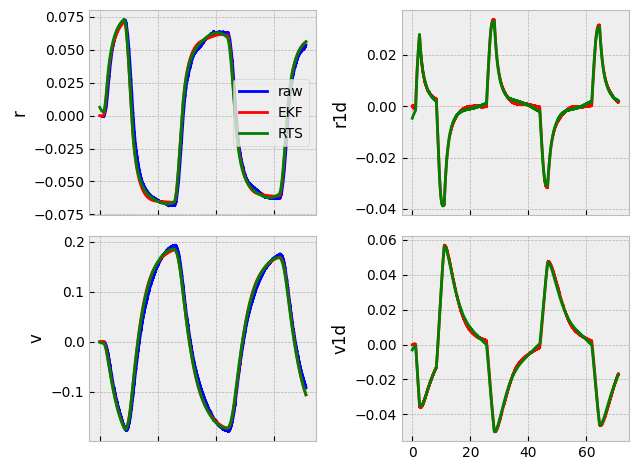

In [71]:
data_ = data.drop(columns=['v1d','r1d'])

dataframes = {
'raw':data_.rolling(window=100).mean(),
'EKF':data_ek,
'RTS':data_ek_smooth,
}
plot(dataframes=dataframes, keys=['v','r','v1d','r1d']);


## Inverse dynamics regression

In [50]:
added_masses = extract_added_masses(parameters=parameters)

In [51]:
data_with_force = predict_force(data=data_ek_smooth, added_masses=added_masses, ship_parameters=ship_data, vmm=vmm)
#data_with_force = predict_force(data=data_ek, added_masses=added_masses, ship_parameters=ship_data, vmm=vmm)

In [52]:
regression, derivatives = fit_motions(data=data_with_force, added_masses=added_masses, ship_data=ship_data, vmm=vmm, exclude_parameters=exclude_parameters)

In [53]:
derivatives

,regressed,$P_{value}$,$conf_{lower}$,$conf_{higher}$
Ndelta,-0.002222,0.000000e+00,-0.002256,-0.002188
Nr,-0.039482,0.000000e+00,-0.041308,-0.037655
Nrrr,0.001781,1.896349e-58,0.001567,0.001996
Nthrustdelta,-0.093714,3.535137e-14,-0.117910,-0.069519
Nur,0.037298,0.000000e+00,0.035498,0.039098
Nv,-0.000505,8.350422e-26,-0.000598,-0.000411
Xdeltadelta,0.001422,3.666346e-97,0.001291,0.001553
Xu,-0.001268,0.000000e+00,-0.001284,-0.001252
Xvr,0.002588,9.254313e-190,0.002420,0.002755
Ydelta,0.004600,NaN,NaN,NaN


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     fx   R-squared (uncentered):                   0.972
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                          8.260e+04
Date:                Tue, 25 Apr 2023   Prob (F-statistic):                        0.00
Time:                        18:02:13   Log-Likelihood:                          50266.
No. Observations:                7107   AIC:                                 -1.005e+05
Df Residuals:                    7104   BIC:                                 -1.005e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Xu             -0.0013   8.09e-06   -156.689      0.000      -0.001      -0.001
Xvr             0.0026   8.54e-05     30.299      0.000       0.002       0.003
Xdeltadelta     0.0014   6.69e-05     21.245      0.000       0.001       0.002
==============================================================================
Omnibus:                      227.660   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              163.798
Skew:                          -0.270   Prob(JB):                     2.70e-36
Kurtosis:                       2.489   Cond. No.                         35.1
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     fy   R-squared (uncentered):                   0.924
Model:                            OLS   Adj. R-squared (uncentered):              0.924
Method:                 Least Squares   F-statistic:                          2.149e+04
Date:                Tue, 25 Apr 2023   Prob (F-statistic):                        0.00
Time:                        18:02:13   Log-Likelihood:                          40365.
No. Observations:                7107   AIC:                                 -8.072e+04
Df Residuals:                    7103   BIC:                                 -8.069e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Yr            -0.0012   6.49e-05    -18.606      0.000      -0.001      -0.001
Yv            -0.0163      0.000    -56.643      0.000      -0.017      -0.016
Yvvv          -0.2034      0.009    -22.726      0.000      -0.221      -0.186
Yvr            0.0021      0.000     10.193      0.000       0.002       0.002
==============================================================================
Omnibus:                      906.788   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              242.032
Skew:                           0.096   Prob(JB):                     2.78e-53
Kurtosis:                       2.116   Cond. No.                         314.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     mz   R-squared (uncentered):                   0.962
Model:                            OLS   Adj. R-squared (uncentered):              0.962
Method:                 Least Squares   F-statistic:                          3.016e+04
Date:                Tue, 25 Apr 2023   Prob (F-statistic):                        0.00
Time:                        18:02:13   Log-Likelihood:                          58342.
No. Observations:                7107   AIC:                                 -1.167e+05
Df Residuals:                    7101   BIC:                                 -1.166e+05
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Ndelta          -0.0022   1.72e-05   -129.337      0.000      -0.002      -0.002
Nr              -0.0395      0.001    -42.372      0.000      -0.041      -0.038
Nv              -0.0005   4.79e-05    -10.544      0.000      -0.001      -0.000
Nrrr             0.0018      0.000     16.267      0.000       0.002       0.002
Nthrustdelta    -0.0937      0.012     -7.593      0.000      -0.118      -0.070
Nur              0.0373      0.001     40.623      0.000       0.035       0.039
==============================================================================
Omnibus:                      213.783   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              120.750
Skew:                           0.154   Prob(JB):                     6.02e-27
Kurtosis:                       2.441   Cond. No.                     8.79e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 8.79e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

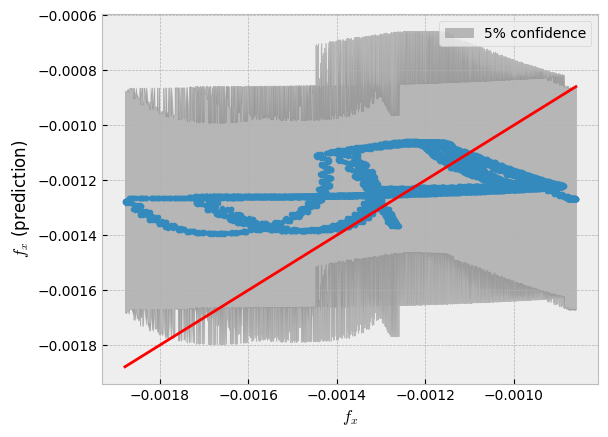

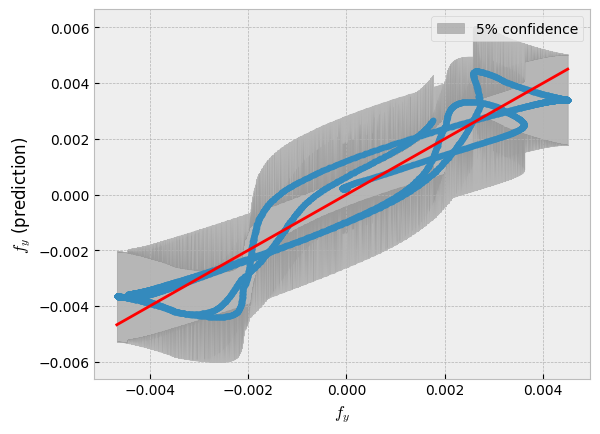

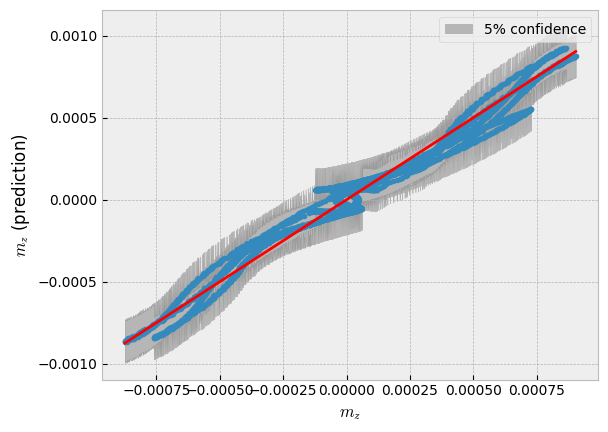

In [54]:
regression.show()

In [55]:
model = create_model_from_motion_regression(regression=regression)

In [56]:
#model.simulate(data_ek_smooth)

In [57]:
data_simulated = simulate_euler(data=data_ek_smooth, model=model, ek=ek)

In [58]:
model_guess = model.copy()
model_guess.parameters = {key:parameters.get(key,0) for key in model.parameters.keys()}
data_simulated_guess = simulate_euler(data=data_ek_smooth, model=model_guess, ek=ek)

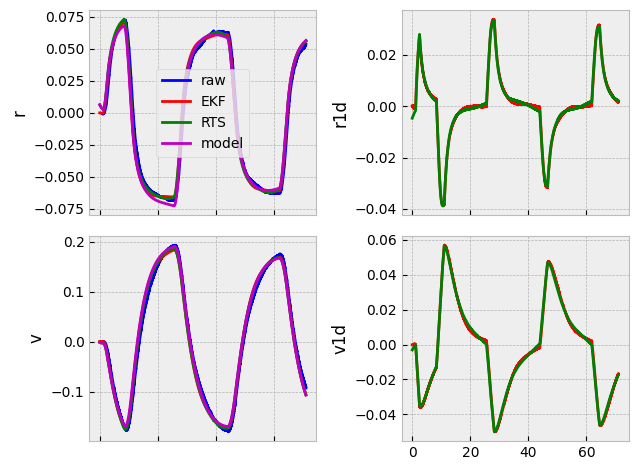

In [74]:
data_ = data.drop(columns=['v1d','r1d'])

dataframes = {
'raw':data_.rolling(window=100).mean(),
'EKF':data_ek,
'RTS':data_ek_smooth,
'model':data_simulated,
}
plot(dataframes=dataframes, keys=['v','r','v1d','r1d']);

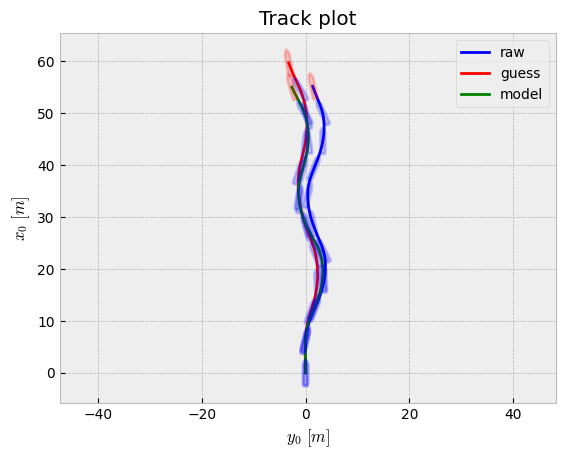

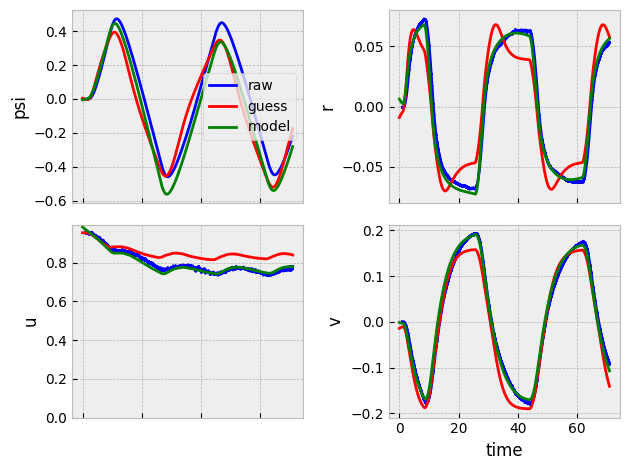

In [76]:

dataframes = {
'raw':data.rolling(100).mean(),
'guess':data_simulated_guess,
'model':data_simulated,
}
track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B']);
plot(dataframes, keys=['u','v','r','psi']);

In [61]:
covariance_matrixes

{'P_prd': [[0.0002777777777777778, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0002777777777777778, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 8.461594994075238e-06, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 2.9999997889107733e-05, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 2.9999997889107733e-05, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 3.316125345456431e-06]],
 'Qd': [[2.9999997889107733e-05, 0.0, 0.0],
  [0.0, 2.9999997889107733e-05, 0.0],
  [0.0, 0.0, 3.316125345456431e-06]],
 'Rd': [[0.0002777777777777778, 0.0, 0.0],
  [0.0, 0.0002777777777777778, 0.0],
  [0.0, 0.0, 8.461594994075238e-06]]}

In [62]:
itterations = []
derivatives = parameters.copy()
covariance_matrixes_itterations = covariance_matrixes.copy()

for i in range(0,5):
    
    ek2, data_ek, time_steps = extended_kalman_filter(ek=ek, data=data, covariance_matrixes=covariance_matrixes_itterations, x0=x0, hydrodynamic_derivatives=derivatives)
    ek_smooth, data_ek_smooth = extended_kalman_smoother(ek=ek2, data=data, time_steps=time_steps, covariance_matrixes=covariance_matrixes_itterations, hydrodynamic_derivatives=derivatives)
    data_with_force = predict_force(data=data_ek_smooth, added_masses=added_masses, ship_parameters=ship_data, vmm=vmm)
    regression, derivatives = fit_motions(data=data_with_force, added_masses=added_masses, ship_data=ship_data, vmm=vmm, exclude_parameters=exclude_parameters)
    model = create_model_from_motion_regression(regression=regression)
    data_simulated = simulate_euler(data=data_ek_smooth, model=model, ek=ek_smooth)
    
    covariance_matrixes_itterations['Qd'] = np.array(covariance_matrixes_itterations['Qd'])*0.7
    
    itterations.append(
        {
            'data_ek':data_ek,
            'data_ek_smooth':data_ek_smooth,
            'derivatives':derivatives,
            'data_simulated':data_simulated,
        }
    )

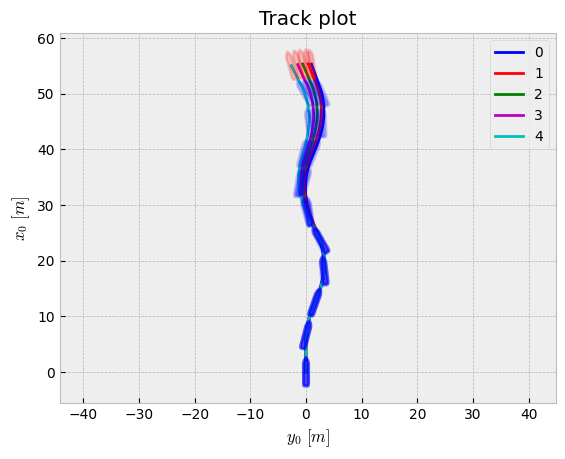

In [63]:
track_plots(dataframes={str(i):itteration['data_simulated'] for i,itteration in enumerate(itterations)}, lpp=ship_data['L'], beam=ship_data['B']);

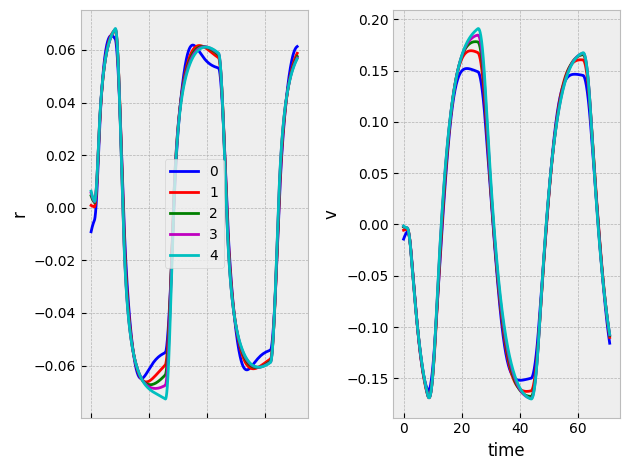

In [64]:
plot(dataframes={str(i):itteration['data_simulated'] for i,itteration in enumerate(itterations)}, keys=['v','r']);

In [65]:
df_MSE = pd.DataFrame()
for dof in ['u','v','r']:
    df_MSE[dof] = pd.Series({i:mean_squared_error(y_true = data[dof], y_pred=itteration['data_simulated'][dof]) for i,itteration in enumerate(itterations)}, name=dof)

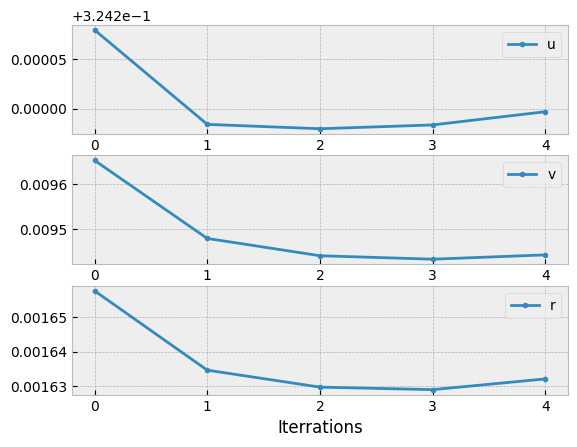

In [66]:
fig,axess =plt.subplots(nrows=3)
for ax,dof in zip(axess,['u','v','r']):
    df_MSE.plot(y=dof, style='.-', ax=ax)
    ax.set_xticks(df_MSE.index)
ax.set_xlabel('Iterrations');


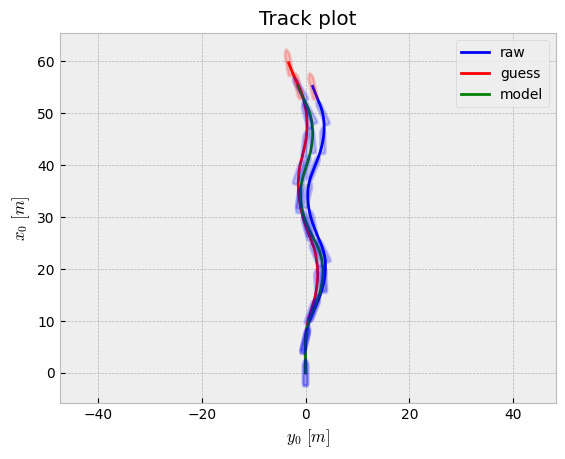

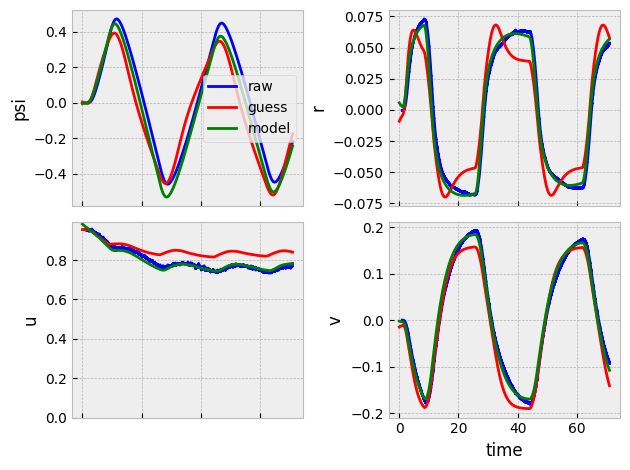

In [77]:
dataframes = {
'raw':data.rolling(100).mean(),
'guess':data_simulated_guess,
'model':itterations[3]['data_simulated'] ,
}
track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B']);
plot(dataframes, keys=['u','v','r','psi']);

In [78]:
parameters

{'Xudot': 0.00017880704448812042,
 'Xdeltadelta': -0.0023882950797979793,
 'Xthrust': 0.883,
 'Xu': -0.0008578977393015612,
 'Xvr': -0.0020600348550005856,
 'Yrdot': -0.00030313777458141895,
 'Yvdot': -0.006109387408263365,
 'Ydelta': 0.005070904026172081,
 'Yr': 0.00274908626901834,
 'Yvvv': -0.13603015841821203,
 'Yv': -0.009478116807560612,
 'Ythrustdelta': 0.8,
 'Yvr': 0.011529803823462739,
 'Nrdot': -0.00029867482773178765,
 'Nvdot': -0.00012825440172375716,
 'Ndelta': -0.0024626510333688027,
 'Nrrr': -0.002873622497682078,
 'Nr': -0.1484739657055087,
 'Nv': -0.0014398058199777241,
 'Nthrustdelta': -0.3864263407084126,
 'Nur': 0.14649565580231366}

In [86]:
compare = pd.concat((itterations[3]['derivatives']['regressed'],pd.Series(parameters, name='vct')), axis=1).dropna().transpose()

<Axes: >

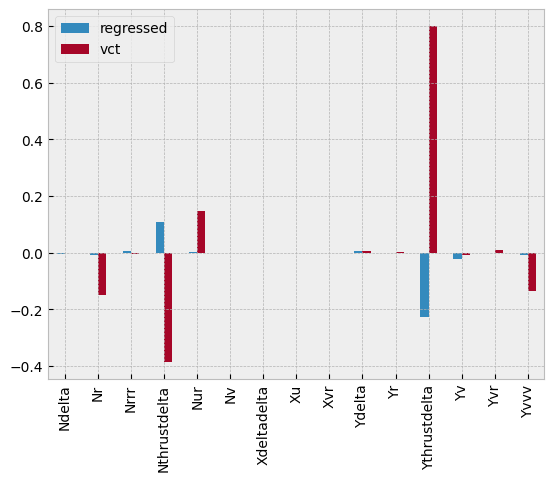

In [89]:
compare.transpose().plot.bar()